# Tutorial 2: Automatic Feature Extraction/Engineering

---

### Introduction

In this notebook, we will extract/engineer features using a deep learning method called autoencoder.
 An autoencoder is an artificial neural network with a symmetric structure which is trained to reconstruct its input at the final output layer. The output of the first half of the network represents an encoding of the input data. ([source](https://arxiv.org/abs/2206.06165)).

First, we import some libraries:

In [1]:
import matplotlib.pyplot as plt # for plotting data/graphs
import numpy as np # For handling N-DIMENSIONAL ARRAYS

import tensorflow as tf #An end-to-end machine learning platform, focusing on training deep learning models
from tensorflow.keras import layers, losses # Implementation of the Keras API, the high-level API of TensorFlow.
from tensorflow.keras.models import Model #This displays graphs
import torchvision.transforms as transforms #Transforms are for common image transformations
import torch


---

### Reading in data
The following code is the same as in Tutorial 1.

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

### Downloading data

First, let us call the python script that will let us download the data.

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()




4422102/4422102 [==============================] - 1s 0us/step


In [6]:
#class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover']
print("Label 0 corresponds to", class_names[0])
print("Label 1 corresponds to", class_names[1])
print("Label 2 corresponds to", class_names[2])


Label 0 corresponds to T-shirt/top
Label 1 corresponds to Trouser
Label 2 corresponds to Pullover


In [17]:
#images_train after reduction of the training sets so that only the labels 0,1,2 are included
images_train = train_images[np.where(train_labels<=2)]
labels_train = train_labels[train_labels<=2]

In [18]:
# defining the training and testing labels and image samples
images_train = train_images[np.where(train_labels<=2)]
images_test = test_images[np.where(test_labels<=2)]
labels_train = train_labels[train_labels<=2]
labels_test = test_labels[test_labels<=2]
classes = class_names


---

### Pre-processing
The following code is the same as in Tutorial 1.

In [25]:
#import pre.py #  A predefined function to pre-process the data as we did in tutorial 1
import torchvision.transforms as transforms
import numpy as np
def pre_processing (data, size = 56):
    #grayscale
    transformGrey = transforms.Grayscale()
    dataGrey = transformGrey(data)
    # reducing the size of the images
    transformResize = transforms.Resize(size)
    dataResized = transformResize(dataGrey)
    #normalize
    #dataPre = dataResized/255
    dataPre = dataResized
    dataPre = np.array(dataPre.reshape(len(dataPre),size,size))

    return dataPre

In [26]:
# Define the transform. The number in parenthesis gives number of pixels per side.
transf = transforms.ToTensor()
transformResize = transforms.Resize(56)


In [27]:
transform = transforms.ToTensor()
liste = []
resize = np.array([images_train.shape[0]])
for i in range(images_train.shape[0]):
  it = transf(images_train[i])
  liste.append(it)
images = torch.stack(liste)

images_trainT = images

transform = transforms.ToTensor()
liste1 = []
resize = np.array([images_test.shape[0]])
for i in range(images_test.shape[0]):
  it = transf(images_test[i])
  liste1.append(it)
images1 = torch.stack(liste1)

images_testT = images1


In [28]:
# pre-processing(data, size) function takes two arguments
# 1. data: the data to be processed
# 2. The size for which the data needs to be reduced.
images_trainPre = pre_processing(images_trainT, 56)
images_testPre = pre_processing(images_testT, 56)

In [29]:
images_trainPre.shape # the shape of the training data

(18000, 56, 56)

Displaying images after pre-processing

label: T-shirt/top


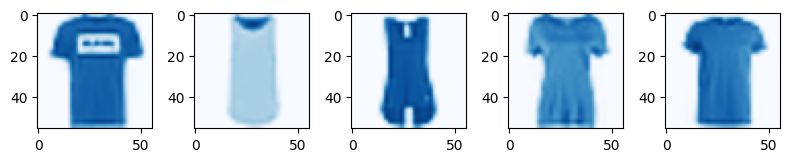

label: Trouser


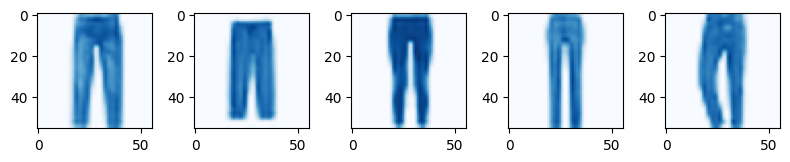

label: Pullover


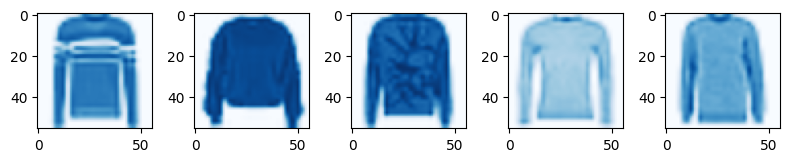

In [30]:
rows = 1
columns = 5
for j in range(len(class_names)):
    fig = plt.figure(figsize=(8, 8))# Figure is 8 inches by 8 inches
    for i in range (columns):    # Create images in each column
        train_image = images_trainPre[(labels_train == j)][i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(train_image*255,cmap='Blues', vmin=0, vmax=255)
                            # we have to multiply the image by 255 to restore the original values
    print("label: "+str(class_names[j]))
    plt.tight_layout()
    plt.show()


---

### Autoencoders
We will try different options for the autoencoder and compare performance. First we'll try a shallow autoencoder with as few layers as possible. Then we'll compare with a deeper autoencoder.

#### Shallow Autoencoder
The autoencoder neural network must have a symmetric structure, and thus must have an even number of layers. We will use a very simple neural network for the autoencoder with just two hidden layers (plus input and output layers). The autoencoder neural network is trained on the data that we pre-processed. The original code can be found [here](https://www.tensorflow.org/tutorials/generative/autoencoder).

In [41]:
latent_dim = 20 # the number of features to be encoded, this can change
num, length, width  = images_trainPre.shape
# need to document how excatly it works

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    # The NN is defined in two parts:encoder and decoder
    # Encoder part:
    self.encoder = tf.keras.Sequential([
      layers.Flatten(), # Input layer-- flattens image into vector
      layers.Dense(latent_dim, activation='relu'), # Dense hidden layer
    ])
    # Decoder part of the NN
    self.decoder = tf.keras.Sequential([
      layers.Dense(length*width, activation='sigmoid'), # Dense hidden layer
      layers.Reshape((length, width)) # Output layer (reshapes vector back to image size)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

##### 1) Define model

In [42]:
shallow_model = Autoencoder(latent_dim)

##### 2) Compile model with Adam optimization

In [43]:
shallow_model.compile(optimizer='adam', loss=losses.MeanSquaredError())

##### 3) Build the model

In [44]:
shallow_model.build((None,56,56,1))

##### 4) Train the model


In the training process we use "early stopping", which automatically terminates training when there is little or no improvement from epoch to epoch.

In [45]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=2)

`EarlyStopping()` has a few options:
- `monitor (default value 'val_loss')`: Uses validation loss as performance measure to terminate the training.
- `patience (default value 0)`: specifies the number of epochs with no improvement. The value 0 means the training is terminated as soon as the performance measure gets worse from one epoch to the next.

We're ready to train the model!

In [46]:
shallow_model.fit(np.array(images_trainPre), np.array(images_trainPre),
                epochs=20,
                shuffle=True,
                validation_data=(np.array(images_trainPre), np.array(images_trainPre)), callbacks=[early_stopping])

Epoch 1/20
563/563 [==============================] - 4s 6ms/step - loss: 0.0310 - val_loss: 0.0191
Epoch 2/20
563/563 [==============================] - 3s 6ms/step - loss: 0.0163 - val_loss: 0.0140
Epoch 3/20
563/563 [==============================] - 3s 5ms/step - loss: 0.0130 - val_loss: 0.0118
Epoch 4/20
563/563 [==============================] - 3s 5ms/step - loss: 0.0114 - val_loss: 0.0106
Epoch 5/20
563/563 [==============================] - 3s 5ms/step - loss: 0.0104 - val_loss: 0.0099
Epoch 6/20
563/563 [==============================] - 3s 6ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 7/20
563/563 [==============================] - 3s 5ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 8/20
563/563 [==============================] - 3s 5ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 9/20
563/563 [==============================] - 3s 5ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 10/20
563/563 [==============================] - 3s 5ms/step - loss: 0.0087 - val_loss: 0.0086

This code runs very fast, because the model is very shallow.

##### 5) Display the model

Now, Let's compare inputs and outputs, and see if they closely resemble each other.

In [47]:
encoded_imgs = shallow_model.encoder(images_testPre).numpy()
decoded_imgs = shallow_model.decoder(encoded_imgs).numpy()

In [48]:
# Check that the output shape is correct
print(decoded_imgs.shape)

(3000, 56, 56)


Original: T-shirt/top


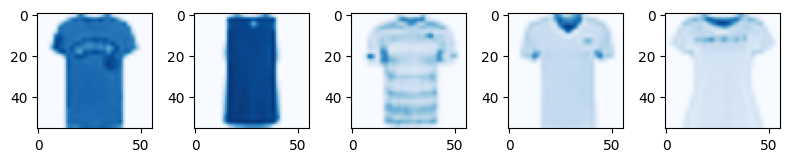

Reconstructed: T-shirt/top


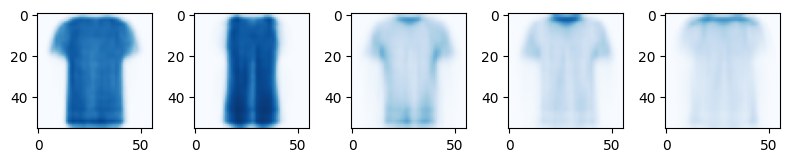

Original: Trouser


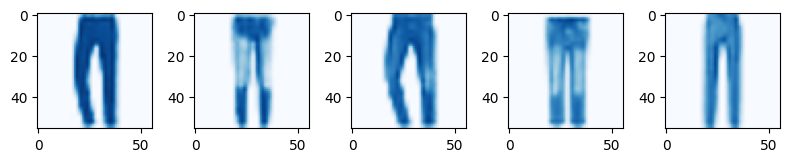

Reconstructed: Trouser


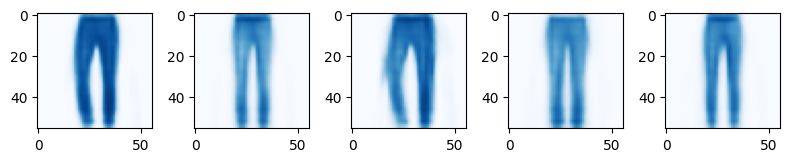

Original: Pullover


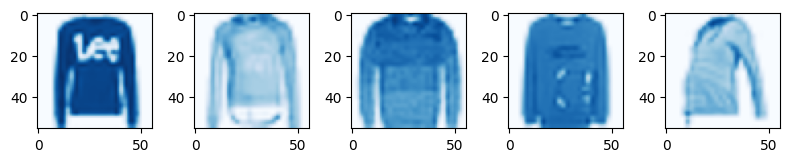

Reconstructed: Pullover


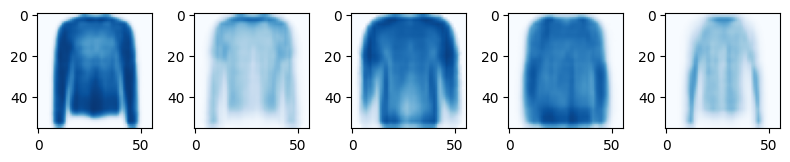

In [49]:
# Display inputs and outputs
rows = 1
columns = 5
for j in range(len(class_names)):
    fig = plt.figure(figsize=(8, 8))# Figure is 8 inches by 8 inches
    for i in range (columns):    # Create images in each column
        test_image = images_testPre[(labels_test == j)][i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(test_image*255,cmap='Blues', vmin=0, vmax=255)
                            # we have to multiply the image by 255 to restore the original values
    print("Original: "+str(class_names[j]))
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(8, 8))# Figure is 8 inches by 8 inches
    for i in range (columns):    # Create images in each column
        test_image = decoded_imgs[(labels_test == j)][i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(test_image*255,cmap='Blues', vmin=0, vmax=255)
                            # we have to multiply the image by 255 to restore the original values
    print("Reconstructed: "+str(class_names[j]))
    plt.tight_layout()
    plt.show()



**Exercise 1:** Which classes do you think will be confused with the others?

In [51]:
### -- Answer here --



###**All classes are both differents**

##### 6) Save the model


In [52]:
shallow_model.save("./shallowModel_save") # saving the model (shallow)

---

#### Deep convolutional autoencoder
A visual comparison of inputs and outputs shows the shallow fully-connected autoencoder does not preserve images very well. So we'll try a more complicated model and compare execution time and image quality. In image classification, convolutional NN's are typically used. So let's try a convolutional NN for our autoencoder. The following autoencoder model is a modified version of the one found [here](https://github.com/ezrafielding/galaxy-cluster/blob/main/autoencoder/galaxyencode.py).

In [53]:
class GalaxyEncoder(Model):
    def __init__(self):
        super(GalaxyEncoder, self).__init__()
        self.encoder = tf.keras.Sequential ([
            layers.InputLayer(input_shape=(56,56,1)),
            layers.Conv2D(16, (3,3), 1, padding="same", activation="relu"),
            layers.MaxPool2D((2,2), padding="same", strides=2),
            layers.Conv2D(8, (3,3), 1, padding="same", activation="relu"),
            layers.MaxPool2D((2,2), padding="same", strides=2),
            layers.Flatten()
        ])
        self.decoder = tf.keras.Sequential ([
            layers.InputLayer(input_shape=(1568)),
            layers.Reshape((14, 14, 8)),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(8, (3,3), 1, padding="same", activation="relu"),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(16, (3,3), 1, padding="same", activation="relu"),
            layers.Conv2D(1, (3,3), 1, padding="same", activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [54]:
deep_model = GalaxyEncoder()

### Exercises ###
Following the procedure that was used above for the shallow model, apply the same steps to the deep model that we have just defined. These steps include: 1) define, 2) compiling, 3) building, 4) training, 5) displaying and 6) saving.   

##### 1) Define

In [55]:
### -- Code here --
deep_model = GalaxyEncoder()


##### 2) compiling

In [56]:
### -- Code here --
deep_model.compile(optimizer='adam', loss=losses.MeanSquaredError())


##### 3) building

In [57]:
### -- Code here --
deep_model.build((None, 56, 56,1))


##### 4) training

In [58]:
### -- Code here --
from tensorflow.keras.callbacks import EarlyStopping
early_stopping1 = EarlyStopping(patience=2)


In [60]:
deep_model.fit(np.array(images_trainPre), np.array(images_trainPre),
                epochs=20,
                shuffle=True,
                validation_data=(np.array(images_trainPre), np.array(images_trainPre)), callbacks=[early_stopping1])

Epoch 1/20
563/563 [==============================] - 7s 12ms/step - loss: 0.0114 - val_loss: 0.0025
Epoch 2/20
563/563 [==============================] - 5s 10ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 3/20
563/563 [==============================] - 5s 9ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 4/20
563/563 [==============================] - 6s 10ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/20
563/563 [==============================] - 4s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/20
563/563 [==============================] - 6s 10ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/20
563/563 [==============================] - 5s 10ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/20
563/563 [==============================] - 5s 9ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/20
563/563 [==============================] - 5s 10ms/step - loss: 9.4876e-04 - val_loss: 9.1274e-04
Epoch 10/20
563/563 [==============================] - 5s 10ms/step - loss: 9.1251e-04

##### 5) displaying

(3000, 56, 56, 1)
Original: T-shirt/top


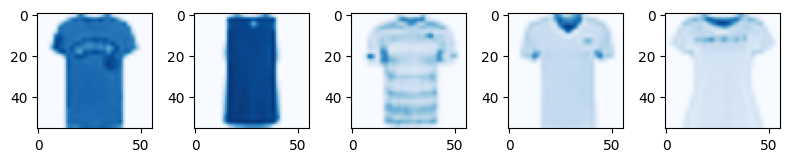

Reconstructed: T-shirt/top


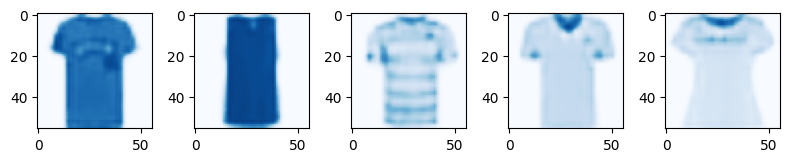

Original: Trouser


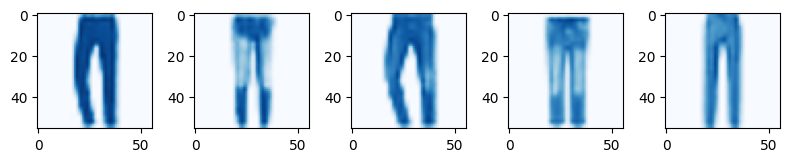

Reconstructed: Trouser


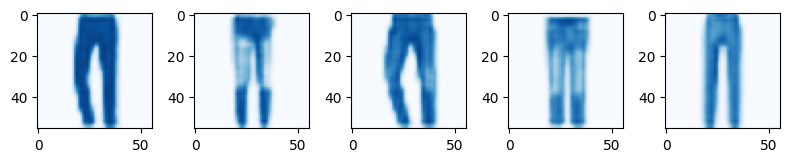

Original: Pullover


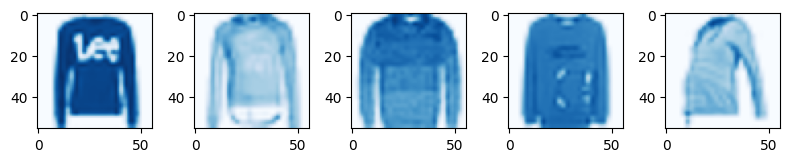

Reconstructed: Pullover


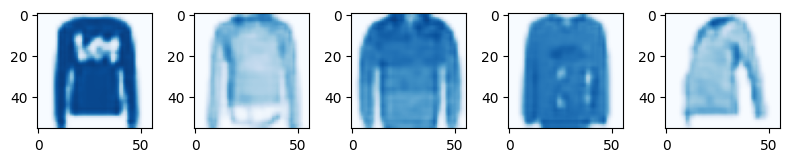

In [61]:
### -- Code here --
#Now, Let's compare inputs and outputs, and see if they closely resemble each other.
encoded_imgs1 = deep_model.encoder(images_testPre).numpy()
decoded_imgs1 = deep_model.decoder(encoded_imgs1).numpy()
# Check that the output shape is correct
print(decoded_imgs1.shape)
# Display inputs and outputs
rows = 1
columns = 5
for j in range(len(class_names)):
    fig = plt.figure(figsize=(8, 8))# Figure is 8 inches by 8 inches
    for i in range (columns):    # Create images in each column
        test_image = images_testPre[(labels_test == j)][i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(test_image*255,cmap='Blues', vmin=0, vmax=255)
                            # we have to multiply the image by 255 to restore the original values
    print("Original: "+str(class_names[j]))
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(8, 8))# Figure is 8 inches by 8 inches
    for i in range (columns):    # Create images in each column
        test_image = decoded_imgs1[(labels_test == j)][i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(test_image*255,cmap='Blues', vmin=0, vmax=255)
                            # we have to multiply the image by 255 to restore the original values
    print("Reconstructed: "+str(class_names[j]))
    plt.tight_layout()
    plt.show()




##### 6) saving

In [62]:
### -- Code here --
deep_model.save("./deepModel_save") # saving the model (shallow)


---

### Extracting the engineered features from the autoencoder model

For now, will continue just with the shallow model. To proceed, we need to extract the 64 encoded features from the shallow encoder model

In [63]:
import tensorflow as tf
import pandas as pd

In [64]:
model = tf.keras.models.load_model('shallowModel_save/') # recalling the model
print(model.summary())

Model: "autoencoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 20)                62740     
                                                                 
 sequential_5 (Sequential)   (None, 56, 56)            65856     
                                                                 
Total params: 128,596
Trainable params: 128,596
Non-trainable params: 0
_________________________________________________________________
None


We may apply the encoder to training and testing data to obtained the encoded features for data item.

In [65]:
auto_features_train = model.encoder.predict(images_trainPre) # extracting the features for the training data
auto_features_test = model.encoder.predict(images_testPre)   # extracting the features for the testing data

94/94 [==============================] - 0s 2ms/step


In [66]:
auto_df_train = pd.DataFrame(auto_features_train) #turning the data into a dataframe
auto_df_test = pd.DataFrame(auto_features_test) #turning the data into a dataframe

In [67]:
print(auto_df_train.shape)

(18000, 20)


In [68]:
auto_df_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,5.417886,17.895113,0.0,0.0,0.0,0.0,0.0,15.339079,12.394889,7.375551,29.970488,1.120940,13.761591,3.897520,0.0,0.0,22.899662,7.91782,0.0,6.506471
1,9.300143,7.686310,0.0,0.0,0.0,0.0,0.0,8.609955,8.131144,6.272532,9.173019,8.809155,11.095397,4.936749,0.0,0.0,6.480858,4.10669,0.0,5.366033
2,21.109709,18.459164,0.0,0.0,0.0,0.0,0.0,3.857858,8.467830,20.822292,15.728785,15.423424,17.362801,3.749298,0.0,0.0,11.320157,5.39871,0.0,4.848963


---

#### **_Saving data for later use_**

We can save the data so that we can call it up again in subsequent notebooks

In [69]:
import pickle
with open('./auto_df_train.pkl','wb') as file:
  pickle.dump(auto_df_train,file)
with open('./auto_df_test.pkl','wb') as file1:
  pickle.dump(auto_df_test,file1)
with open('./labels_train.pkl','wb') as file2:
  pickle.dump(labels_train,file2)
with open('./labels_test.pkl','wb') as file3:
  pickle.dump(labels_test,file3)
with open('./classes.pkl','wb') as file4:
  pickle.dump(classes,file4)